# Nursery Scenario

In [1]:
from NN import *
from LTL import *

from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
from matplotlib import pyplot as plt
import time

Number of Omega-automaton states (including the trap state): 55


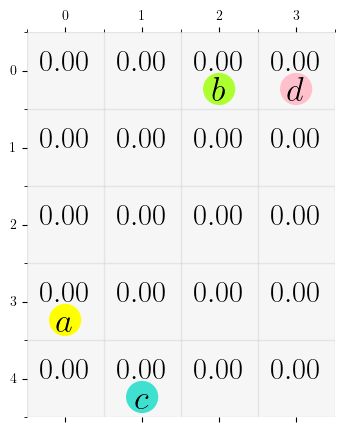

In [2]:
### from the Nursary case ###
# LTL Specification
# ltl = ('G ('
#     '(!d) & '
#     '((b & (!(X b)))->(X ((!b) U (a|c)))) & '
#     '(((!b) & (X b) & (!(X X b)))->((!a) U c)) & '
#     '(a->(X ((!a) U b))) & '
#     '(c->((!a) U b)) & '
#     '((b & (X b))->(F a))'
# ')')

ltl = ('G ('
    '(!d) & '
    '(c->((!a) U b)) & '
    '((b & (X b))->(F a)) & '
    '((b & (!(X b)))->(X ((!b) U (a|c)))) & '
    '(((!b) & (X b) & (!(X X b)))->((!a) U c)) &'
    '(a->(X ((!a) U b))) '
')')

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])

# MDP Description
shape = (5,4)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
# ['E',  'E',  'E',  'E'],
# ['E',  'E',  'E',  'E'],
# ['E',  'E',  'E',  'E'],
# ['E',  'E',  'E',  'E'],
# ['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),    (),    ('b',),('d',)],
[(),    (),    (),    ()],
# [(),    (),    (),    ()],
# [(),    (),    (),    ()],
# [(),    (),    (),    ()],
# [(),    (),    (),    ()],
# [(),    (),    (),    ()],
[(),    (),    (),    ()],
[('a',),(),    (),    ()],
[(),    ('c',),(),    ()]
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'yellow',
    ('b',):'greenyellow',
    ('c',):'turquoise',
    ('d',):'pink'
} 
p = 1
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

In [3]:
csrl.shape, csrl.ch_states[(0,0,0,0)].shape, max_rew

((1, 55, 5, 4, 59), (5, 4, 55), 0.01)

In [4]:
model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 4, 55)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 5, 4, 32)     7072        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 4, 8)      1032        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 160)          0           ['conv2d_1[0][0]']               
                                                                                              

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.pdf', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
t = "[] ( (~d) /\ (c->(~a % b)) /\ ((b /\ >b) -> <>a) /\ ((b /\ ~>b) -> >(~b % (a \/ c))) /\ ((~b /\ >b /\ ~>>b)->(~a % c)) )"

full_t = "[] ( (~d) /\ ((b /\ ~>b) -> >(~b % (a \/ c))) /\ (a -> >(~a % b))"
full_t += " /\ ((~b /\ >b /\ ~>>b)->(~a % c)) /\ (c->(~a % b)) /\ ((b /\ >b) -> <>a) )"

LTL_formula = parser.parse(full_t)
predicates=grid_mdp.get_predicates()

### proof of satifying trajectory ###
tra = [2,3]
print(len(tra), check_LTL(LTL_formula, tra, predicates))
#######

2 []


In [20]:
predicates

{'a': [12], 'b': [2], 'c': [17], 'd': [3]}

In [21]:
model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])

N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)

In [22]:
model.load_weights(f'models/p=1/Nurseryp1')

In [24]:
global LTL_coef
LTL_coef = 0.5
visited_states_train = []
visited_states_test = []

search_depth = 100
MCTS_samples = 100

num_training_epochs =  100
num_test_epochs = 100
training = True
epochs = 20
T = [200]
K = 1

success_rates = []
succes_std = []
win_hist = []
train_history = []

for i in T:
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = int(200 - 1.9*i)
    # model = build_model(csrl.ch_states[(0,0,0,0)].shape, csrl.shape[-1])
    N, W, Q, P, visited = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = csrl.MC_learning(model, LTL_formula, predicates,
                csrl.reward, N = N, W = W, Q = Q, P = P, C=3, tow=0.7, n_samples=MCTS_samples, visited=visited, start=(4,1), search_depth=search_depth,
                verbose=0, T=i, K=K)
        # print('N',N[(0,0,4,1)][:5])
        visited_states_train += state_history
        t2 = time.time()
        # print(t2-t1, " run episode")

        win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if win: train_wins+=1

        t3= time.time()
        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + 0.5*(check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
                # y2_train = np.array(reward_history)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + 0.5*(check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
                # y2_train_curr = np.array(reward_history)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, verbose=0)
            train_history += tr_hist.history['loss']
        win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, " fit")
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = csrl.MC_learning(model, LTL_formula, predicates,
                csrl.reward, N = N, W = W, Q = Q, P = P, C=3, tow=0.7, n_samples=100, visited=visited, start=(4,1), search_depth=search_depth, verbose=0, T=i, K=1)

        win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if win: test_wins+=1
        win_hist.append(win)
        visited_states_test += state_history
        
    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

LTL [---]  LDBA [ 0.12 ] path: [17, 17, 16, 16, 17, 13, 9, 5, 1, 2, 6, 5, 9, 13, 17, 13, 9, 5, 1, 2, 2, 6, 10, 9, 13, 12, 13, 14, 10, 6, 2, 2, 1, 0, 4, 8, 12, 16, 17, 13, 9, 5, 1, 2, 2, 6, 10, 9, 13, 12, 13, 14, 10, 6, 2, 2, 1, 0, 4, 8, 12, 8, 9, 5, 6, 2, 2, 1, 0, 4, 8, 12, 16, 17, 13, 9, 5, 1, 2, 2, 6, 10, 9, 13, 12, 13, 14, 10, 6, 2, 2, 1, 0, 4, 8, 12, 8, 9, 5, 9, 10, 6, 2, 2, 1, 0, 4, 8, 12, 8, 9, 5, 9, 10, 6, 2, 2, 1, 0, 4, 8, 12, 8, 9, 5, 9, 10, 6, 2, 2, 1, 0, 4, 8, 12, 8, 9, 5, 9, 10, 6, 2, 2, 1, 0, 4, 8, 12, 8, 9, 5, 9, 10, 6, 2, 2, 1, 0, 4, 8, 12, 8, 9, 5, 6, 2, 2, 1, 0, 4, 8, 12, 8, 9, 5, 6, 2, 2, 1, 0, 4, 8, 12, 8, 9, 5, 6, 2, 2, 1, 0, 4, 8, 12, 8, 9, 5, 9, 10, 6]
LTL [---]  LDBA [ 0.13 ] path: [17, 17, 16, 16, 16, 17, 13, 9, 5, 1, 2, 6, 5, 9, 13, 17, 13, 9, 5, 1, 2, 2, 6, 10, 9, 13, 12, 13, 14, 10, 6, 2, 2, 1, 0, 4, 8, 12, 8, 9, 5, 9, 10, 6, 2, 2, 1, 0, 4, 8, 12, 8, 9, 5, 9, 10, 6, 2, 2, 1, 0, 4, 8, 12, 8, 9, 5, 6, 2, 2, 1, 0, 4, 8, 12, 16, 17, 13, 9, 5, 1, 2, 2, 6, 10, 9, 1

Text(0.5, 1.0, 'MCTS - histogram of visited states during traning')

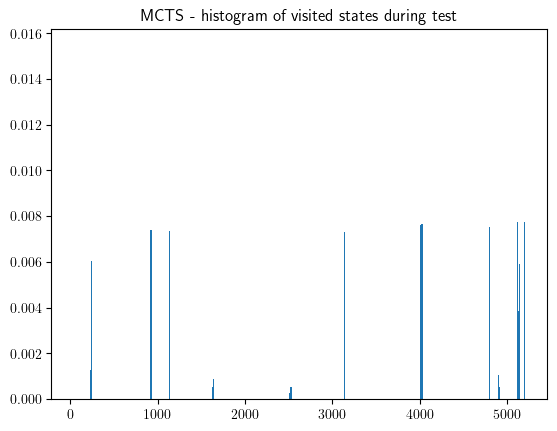

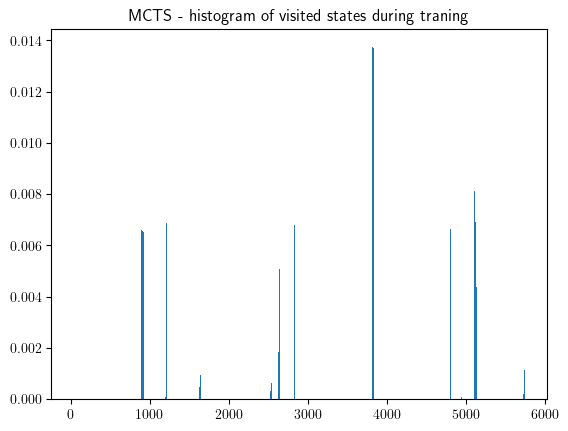

In [55]:
plt.hist([i[1]*100+i[2]*10+i[3] for i in visited_states_test],1060, density=True)
plt.title("MCTS - histogram of visited states during test")

plt.figure()

plt.hist([i[1]*100+i[2]*10+i[3] for i in visited_states_train],1060, density=True)
plt.title("MCTS - histogram of visited states during traning")

Text(0.5, 1.0, 'CSRL - histogram of visited states during traning')

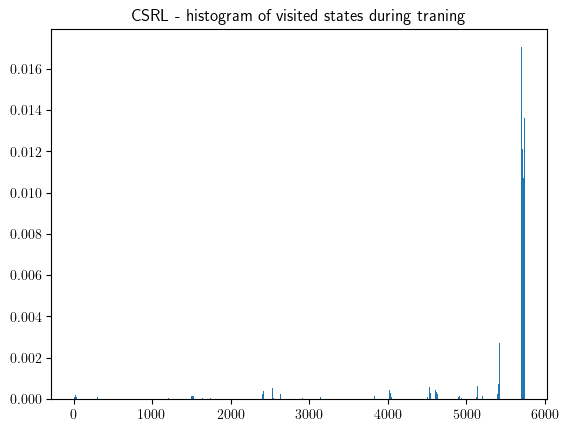

In [9]:
plt.hist([i[1]*100+i[2]*10+i[3] for i in hist],1060, density=True)
plt.title("CSRL - histogram of visited states during traning")

In [17]:
len(np.unique([i[1]*100+i[2]*10+i[3] for i in hist]))

453

In [8]:
from collections import Counter
import pickle

In [59]:
with open("visited_states_train", "wb") as fp:   #Pickling
  pickle.dump(visited_states_train, fp)

with open("visited_states_test", "wb") as fp:   #Pickling
  pickle.dump(visited_states_test, fp)

In [11]:
with open("visited_states_test", "rb") as fp:   # Unpickling
    visited_states_test = pickle.load(fp)

with open("visited_states_train", "rb") as fp:   # Unpickling
    visited_states_train = pickle.load(fp)

In [57]:
Counter([i[1]*100+i[2]*10+i[3] for i in visited_states_test])

Counter({41: 65,
         1641: 69,
         1642: 40,
         4941: 43,
         1631: 65,
         4921: 65,
         4920: 67,
         4910: 65,
         4900: 66,
         4901: 67,
         4902: 65,
         2412: 65,
         2511: 31,
         2521: 31,
         2531: 31,
         2541: 65,
         2631: 337,
         5121: 494,
         5111: 570,
         5101: 570,
         5102: 979,
         5202: 978,
         1212: 976,
         3822: 976,
         3821: 974,
         3831: 974,
         3830: 973,
         2831: 970,
         4032: 969,
         4022: 967,
         4012: 964,
         4002: 960,
         4802: 955,
         5001: 950,
         900: 947,
         910: 945,
         920: 938,
         930: 934,
         1140: 932,
         3141: 927,
         241: 765,
         2642: 491,
         5142: 430,
         5132: 488,
         5122: 488,
         5112: 488,
         5143: 148,
         2640: 127,
         5141: 126,
         231: 159,
         1202: 66,
     

In [49]:
visited_states_test

[(0, 0, 4, 1),
 (0, 16, 4, 1),
 (0, 16, 4, 1),
 (0, 16, 4, 0),
 (0, 49, 4, 0),
 (0, 49, 4, 0),
 (0, 49, 4, 1),
 (0, 16, 3, 1),
 (0, 49, 2, 1),
 (0, 49, 2, 0),
 (0, 49, 1, 0),
 (0, 49, 0, 0),
 (0, 49, 0, 1),
 (0, 49, 0, 1),
 (0, 49, 0, 2),
 (0, 24, 1, 2),
 (0, 25, 1, 1),
 (0, 25, 2, 1),
 (0, 25, 3, 1),
 (0, 25, 4, 1),
 (0, 26, 3, 1),
 (0, 51, 2, 1),
 (0, 51, 1, 1),
 (0, 51, 0, 1),
 (0, 51, 0, 2),
 (0, 52, 0, 2),
 (0, 12, 0, 2),
 (0, 12, 1, 2),
 (0, 38, 2, 2),
 (0, 38, 2, 1),
 (0, 38, 3, 1),
 (0, 38, 3, 0),
 (0, 28, 3, 1),
 (0, 40, 3, 2),
 (0, 40, 2, 2),
 (0, 40, 1, 2),
 (0, 40, 0, 2),
 (0, 48, 0, 2),
 (0, 50, 0, 1),
 (0, 9, 0, 0),
 (0, 9, 1, 0),
 (0, 9, 2, 0),
 (0, 9, 3, 0),
 (0, 11, 4, 0),
 (0, 31, 4, 1),
 (0, 2, 3, 1),
 (0, 51, 2, 1),
 (0, 51, 1, 1),
 (0, 51, 0, 1),
 (0, 51, 0, 2),
 (0, 52, 0, 2),
 (0, 12, 1, 2),
 (0, 38, 2, 2),
 (0, 38, 2, 1),
 (0, 38, 3, 1),
 (0, 38, 3, 0),
 (0, 28, 3, 1),
 (0, 40, 3, 2),
 (0, 40, 2, 2),
 (0, 40, 1, 2),
 (0, 40, 0, 2),
 (0, 48, 0, 2),
 (0, 50, 0, 1)

In [ ]:
bk_wins = win_hist.copy()

0.8

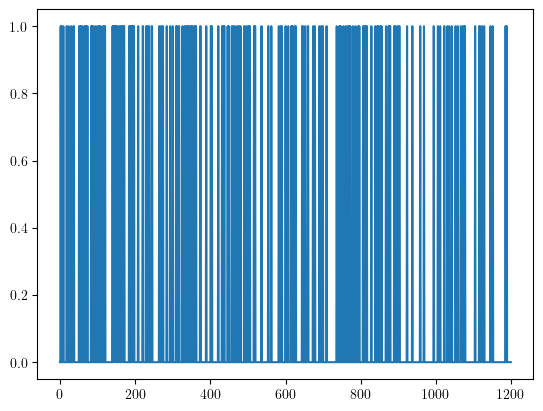

In [ ]:
plt.plot(win_hist)
p

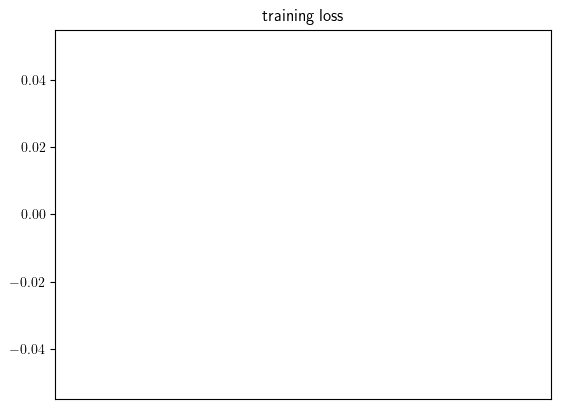

In [ ]:
plt.plot(train_history)
plt.title("training loss")
plt.xticks(range(1,num_training_epochs*epochs,100), range(0,num_training_epochs,100//epochs));

In [ ]:
len(range(1,2000,100))

20

In [ ]:
model.save_weights(f'models/Nurseryp{p}')

In [ ]:
model.load_weights('models/Nurseryp1')

[28.0, 18.5, 15.0, 15.5, 12.5, 10.5]

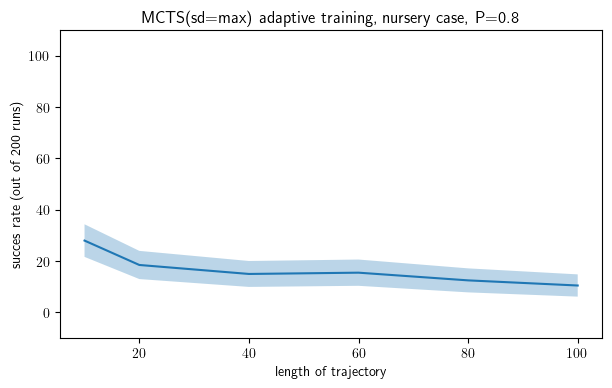

In [ ]:
succes_std = np.array(succes_std)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3, label="MCTS area of 1 STD")

plt.plot(T, success_rates)
plt.ylim(-10, 110)
plt.xlabel("length of trajectory")
plt.ylabel(f"succes rate (out of {num_test_epochs} runs)")
plt.title("MCTS(sd=max) adaptive training, nursery case, P="+str(p))
success_rates

In [ ]:
from ipywidgets.widgets import IntSlider
from ipywidgets import interact

def plot_agent(t):
    csrl.mdp.plot(agent=state_history[t][2:], save=f'test/{t}.png')
t=IntSlider(value=0,min=0,max=T[-1]-1)
interact(plot_agent,t=t)

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_agent(t)>

In [ ]:
csrl.reward[0,3,4,1]
p = 0.8

In [ ]:
Q = np.load(f'Q2_{p}.npy')

In [6]:
Q, hist=csrl.q_learning(T=100,K=100000)
np.save(f'Q2_{p}', Q)

In [ ]:
policy=np.argmax(Q,axis=4)
value=np.max(Q,axis=4)

In [ ]:
policy=np.argmax(Q,axis=4)
# csrl.plot(value,policy,iq=(0,0),save='safe_absorbing_states_policy.pdf')
csrl.plot(value,policy)

interactive(children=(IntSlider(value=0, description='i', max=0), IntSlider(value=0, description='q', max=57),…

In [ ]:
T = [10, 20, 40, 60, 80, 100, 200, 400]
# success_rates= [0.0, 5.0, 10.0, 14.0, 15.0, 17.0, 17.0]
success_rates = [28.0, 18.5, 15.0, 15.5, 12.5, 10.5, 5, 1]
# success_rates= [97, 100, 100, 100, 100, 100, 1000, 100, 100, 100]
# success_rates= [79, 83, 73, 78, 83, 85, 88, 85, 86, 82]
succes_std = []
for i in success_rates:
    temp = np.zeros(100)
    temp[:int(i)]=1
    std = np.sqrt(100*np.var(temp))
    succes_std.append((i-std, i+std))
succes_std = np.array(succes_std)

In [ ]:
rewards_mean = []
rewards_std = []
n_runs = 200

x = list(range(3,100,1))
for i in T:
    episodes, rew = csrl.run_Q_test(policy, LTL_formula, predicates, T=i, start=(4,1), runs=n_runs, verbose=0)
    rewards_mean.append(100*np.mean(rew))
    rewards_std.append((rewards_mean[-1]-np.sqrt(n_runs*np.var(rew)), rewards_mean[-1]+np.sqrt(n_runs*np.var(rew))))
rewards_std = np.array(rewards_std)

Running 200 simulations with 10 time-steps...
Test finished with:
	success rate: 11 / 200 = 0.055
Running 200 simulations with 20 time-steps...
Test finished with:
	success rate: 41 / 200 = 0.205
Running 200 simulations with 40 time-steps...
Test finished with:
	success rate: 33 / 200 = 0.165
Running 200 simulations with 60 time-steps...
Test finished with:
	success rate: 36 / 200 = 0.18
Running 200 simulations with 80 time-steps...
Test finished with:
	success rate: 35 / 200 = 0.175
Running 200 simulations with 100 time-steps...
Test finished with:
	success rate: 28 / 200 = 0.14
Running 200 simulations with 200 time-steps...
Test finished with:
	success rate: 33 / 200 = 0.165
Running 200 simulations with 400 time-steps...
Test finished with:
	success rate: 41 / 200 = 0.205


In [ ]:
rewards_mean

[4.1000000000000005,
 19.8,
 15.5,
 16.900000000000002,
 16.3,
 14.899999999999999,
 16.1,
 16.8]

Text(0.5, 1.0, 'CSRL performance results on the second case study, P=0.8')

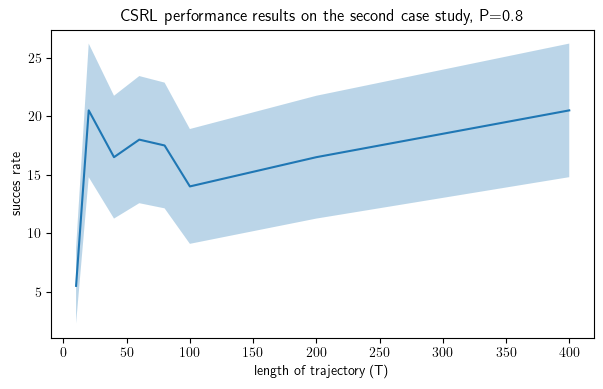

In [ ]:
plt.figure(figsize=(7,4))
plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3, label="1 STD")

plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("CSRL performance results on the second case study, P="+str(p))

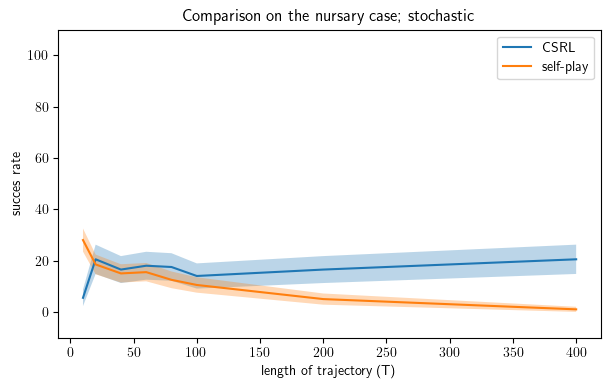

In [ ]:
plt.figure(figsize=(7,4))

plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3)
plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("Comparison on the nursary case; stochastic")
# plt.title("Comparison on the nursary case; deterministic")
plt.ylim(-10, 110)

plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)
plt.plot(T, success_rates, label="self-play")
plt.legend()
plt.savefig(f"res_400/C2_P{p}.pdf")

<Figure size 640x480 with 0 Axes>

In [ ]:
episode=csrl.simulate(policy, LTL_formula, predicates, start=(4,1),T=100)
episode[1]

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

False

In [ ]:
episode, rew =csrl.simulate(policy, LTL_formula, predicates, start=(9,1),T=100,plot=True)
elements, counts = np.unique(np.array(episode)[:,1], return_counts=True)
sorted(zip(elements,counts),key=lambda x:-x[1])

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

[(21, 39), (24, 36), (14, 5), (4, 4), (8, 4), (9, 4), (23, 4), (26, 4), (0, 1)]

In [ ]:
csrl.reward.shape

(1, 55, 5, 4)

In [ ]:
episodes, rewards = csrl.run_Q_test(policy, LTL_formula, predicates, start=(9,1),T=100, runs=100, verbose=0)

Running 100 simulations with 100 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0


In [ ]:
def plot_agent(t):
    csrl.mdp.plot(agent=state_history[t][2:], save=f'test/{t}.png')
t=IntSlider(value=0,min=0,max=T-1)
interact(plot_agent,t=t)

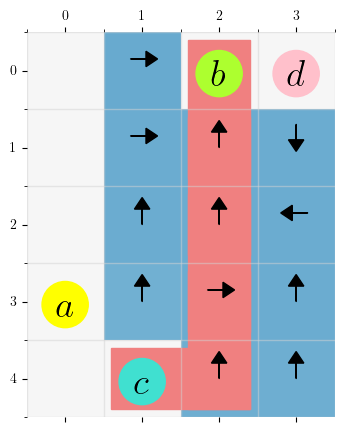

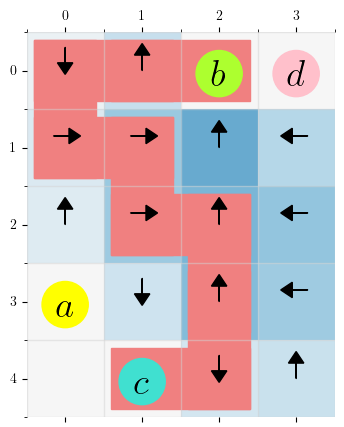

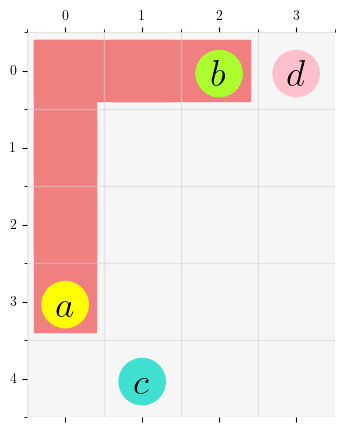

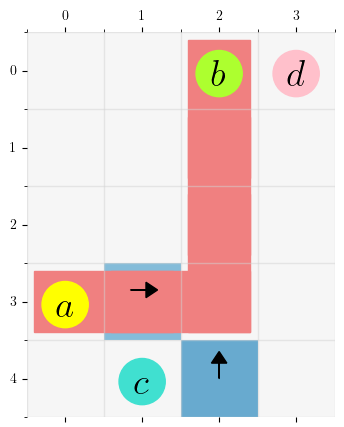

In [ ]:
# Plot the important parts of the policy

policy=np.argmax(Q,axis=4)

hidden = [(0,0),(1,0),(2,0),(3,0),(4,0),(4,1),(0,2),(0,3)]
path = {
    (4,1) : 'r',
    (4,2) : 'lu',
    (3,2) : 'du',
    (2,2) : 'du',
    (1,2) : 'du',
    (0,2) : 'd'
}
csrl.plot(value,policy,iq=(0,2),save='nursery_scenario_policy_cb.pdf',path=path,hidden=hidden)


hidden = [(3,0),(4,0),(4,1),(0,2),(0,3)]
path = {
    (0,2) : 'l',
    (0,1) : 'lr',
    (0,0) : 'rd',
    (1,0) : 'ur',
    (1,1) : 'ld',
    (2,1) : 'ur',
    (2,2) : 'ld',
    (3,2) : 'ud',
    (4,2) : 'ul',
    (4,1) : 'r'
}
csrl.plot(value,policy,iq=(0,41),save='nursery_scenario_policy_bc.pdf',hidden=hidden,path=path)

hidden=[(3,0),(4,0),(4,1),(4,2),(4,3),(0,2),(0,3)]
path = {
    (0,2) : 'l',
    (0,1) : 'lr',
    (0,0) : 'rd',
    (1,0) : 'ud',
    (2,0) : 'ud',
    (3,0) : 'u'
}
csrl.plot(value,policy,iq=(0,12),save='nursery_scenario_policy_ba.pdf',hidden=hidden,path=path)

hidden=[(3,0),(4,0),(0,2),(0,3),(4,1)]
path = {
    (3,0) : 'r',
    (3,1) : 'lr',
    (3,2) : 'lu',
    (2,2) : 'du',
    (1,2) : 'du',
    (0,2) : 'd'
}
csrl.plot(value,policy,iq=(0,9),save='nursery_scenario_policy_ab.pdf',hidden=hidden,path=path)

In [ ]:
# Save the animation
episode=csrl.simulate(policy,start=(4,1),T=100, animation='test')

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…